# Multimodal Data
#### Amani MOKNI et Caio ELMOR LANG

#### [EN]
The main objective of this project is to understand if the use of multimodal data can improve the classification power of a model.
It consists in an environment classification problem, where the environment must be chosen between 9 classes (Beach/City/Forrest/Classroom/Restaurant…) using images and ambient audio as inputs.

The goal is then to combine these two data sources to create a performing model.

In the beggining of the project, we have made a classifier using only the audio data, with a Support Vector Machine (SVM) with an RBF kernel.
The score obtained for this strategy was **94,028%** on Kaggle. The corresponding Notebook is in this repo as `audio_only.ipynb`.

Then, we've made a submission using only image data, which led to a score of **94,811%**.

Finally, we have used a network that has as input the image and audio data, and that resulted in a score of **99,65%**.

This Notebook shows the process used in the development of the models and their validation.

------------
#### [FR]
L'objectif fondamental de ce projet est de valider si l'utilisation de données multimodals apporte au pouvoir de classification d'un modèle.
En effet, il s'agit d'un problème de classification d’environnement entre 9 classes (Beach/City/Forrest/Classroom/Restaurant…) à partir des images et des audios qui sont entrés comme données.

Alors le but est de combiner les sources et trouver un modéle performant.

Au début du projet, on a fait une classification à partir des données audio seulment, avec une SVM de kernel RBF.
Le score obtenu pour cette stratégie était de **94,028%** sur Kaggle. Le Notebook utilisé est `audio_only.ipynb`.

Après, on a fait une submission en utilisant seulement des données d'image, ce qui nous a apporté un score de **94,811%**.

Finalement, on a fait une réseau qui admet comme entrée les données d'image et d'audio, et cela nous a donné comme résultat **99,65%** comme score.

Ce Notebook montre la démarche utilisé dans le développement des modèles et leurs validation.

### 1. Initial Configurations | _Configurations initiales_

We'll start by importing the necessary libraries

_Tout d'abord, on commence par importer les bibliothéques nécessaires_

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torchvision
import torch
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import torchvision.models
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.model_selection import KFold

ModuleNotFoundError: No module named 'torchvision'

Then, we read the training and test data

_Puis, on lit les données d'apprentissage et de test_

In [2]:
datadir = '/kaggle/input/multimodal-classification-2021-mi203/data'
# original data taken from: https://www.kaggle.com/birdy654/scene-classification-images-and-audio

#-------- TRAIN -------------
data_df = pd.read_csv(os.path.join(datadir,'data_train.csv'), delimiter=',', nrows = None)
data = np.array(data_df)
# labels = data[:100,-1].astype('int32')
# audio = data[:100, 1:-1].astype('float32')
# img_list = data_df.loc[:99,'IMAGE']
labels = data[:,-1].astype('int32')
audio = data[:, 1:-1].astype('float32')
img_list = data_df['IMAGE']

#-------- TEST --------------
test_data_df = pd.read_csv(os.path.join(datadir,'data_test_novt.csv'), delimiter=',', nrows = None)
test_data = np.array(test_data_df)

test_audio = test_data[:, 1:].astype('float32')
test_img_list = test_data_df['IMAGE']

Here, we verify the amount of data for training and for inference:

_Ici, on vérifie la quantité et la configuration des données pour l'entrainement et pour la prédiction:_

In [3]:
print("training data ", len(img_list))
print("test data: ", len(test_img_list))

training data  13802
test data:  3450


Before implementing the model, we'll start by checking the data formatting.

_Avant de commencer l'implémentation du model, on commence par avoir une idée sur le format des données.
Ci-dessous quelques échantillons:_

In [4]:
data_df.head()

,IMAGE,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_96,mfcc_97,mfcc_98,mfcc_99,mfcc_100,mfcc_101,mfcc_102,mfcc_103,mfcc_104,CLASS
0,trainimg_00000.png,11.112999,4.439105,-2.558765,4.686579,-3.489522,-7.244747,-1.815565,-0.980045,-10.464417,...,7.734828,-24.234226,7.036733,-9.169885,-2.371813,-13.772405,-23.100386,-11.933302,-14.578534,3
1,trainimg_00001.png,13.567897,-1.470553,-6.175936,-18.168946,-2.104478,-19.821045,15.739972,-7.928797,-4.354971,...,18.260046,-27.219082,36.595292,-18.729583,-17.238996,-1.950551,-44.563617,14.197092,-9.513413,0
2,trainimg_00002.png,12.585137,1.143402,-10.662741,-0.545328,9.144298,4.423014,9.070376,8.215766,9.191786,...,20.081282,-30.869050,30.302531,-13.525306,5.084584,23.202085,-2.831217,9.582895,0.731367,3
3,trainimg_00003.png,17.783320,4.445305,-17.644072,-13.889671,4.218943,-19.305793,-4.337773,-15.685792,-10.368791,...,15.439014,-38.117531,11.502297,-24.402804,-9.283201,-3.905179,-13.833009,-5.714941,-6.054448,4
4,trainimg_00004.png,12.348299,-11.143099,-24.030269,-29.444278,38.216061,-36.566694,15.501984,-24.954497,15.796076,...,32.459378,-30.386077,7.219499,-24.596709,28.042625,0.587357,-38.040484,21.121838,5.865456,5


In [5]:
test_data_df.head()

,IMAGE,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_95,mfcc_96,mfcc_97,mfcc_98,mfcc_99,mfcc_100,mfcc_101,mfcc_102,mfcc_103,mfcc_104
0,testimg_00000.png,16.843997,-3.527753,-21.282970,-24.248141,27.201589,-18.787674,30.093938,-1.922008,10.156418,...,-28.511534,17.568753,-36.410615,19.949251,-5.466172,6.480569,13.070739,-14.853299,10.243606,-17.983957
1,testimg_00001.png,21.689841,-15.971450,-26.837817,-46.561006,20.770073,-8.153000,16.801556,-4.589764,7.219863,...,-53.901470,34.091023,-21.613514,42.223289,-11.695203,2.910106,-35.891702,-2.755247,-2.448610,13.279929
2,testimg_00002.png,15.885028,-3.446543,-20.357212,-17.271980,5.853781,-20.039931,8.527755,-8.273115,-2.867482,...,-24.242269,16.169284,-43.660615,17.082230,-25.663614,-15.074513,-6.519667,-21.193189,10.584720,-0.512312
3,testimg_00003.png,20.132288,-17.284216,-17.565541,-44.360317,25.779903,-31.732558,1.954070,-33.830296,9.555620,...,-22.248038,17.956718,-49.163853,10.988654,-22.518518,-5.554690,3.229284,-30.206648,21.092678,-2.877422
4,testimg_00004.png,18.871526,-5.017444,-34.219745,-44.331733,31.959383,-37.833432,26.433732,-1.085807,10.271224,...,-27.101495,16.100569,-36.373091,16.555135,-18.220053,-5.352182,6.581531,-22.221355,-6.621101,-11.029499


### 2. First data visualisation | _Premières visualisations des données_

The following visualisation shows the **Class distribution** of the training data.

_On a fait ensuite quelques visualisations, comme la **Distribution des classes** dans les données d'apprentissage. C'est une fonction qui associe une fréquence d'apparition à une classe de valeur. Cette fonction permet de résumer l'information contenue dans un ensemble de données._

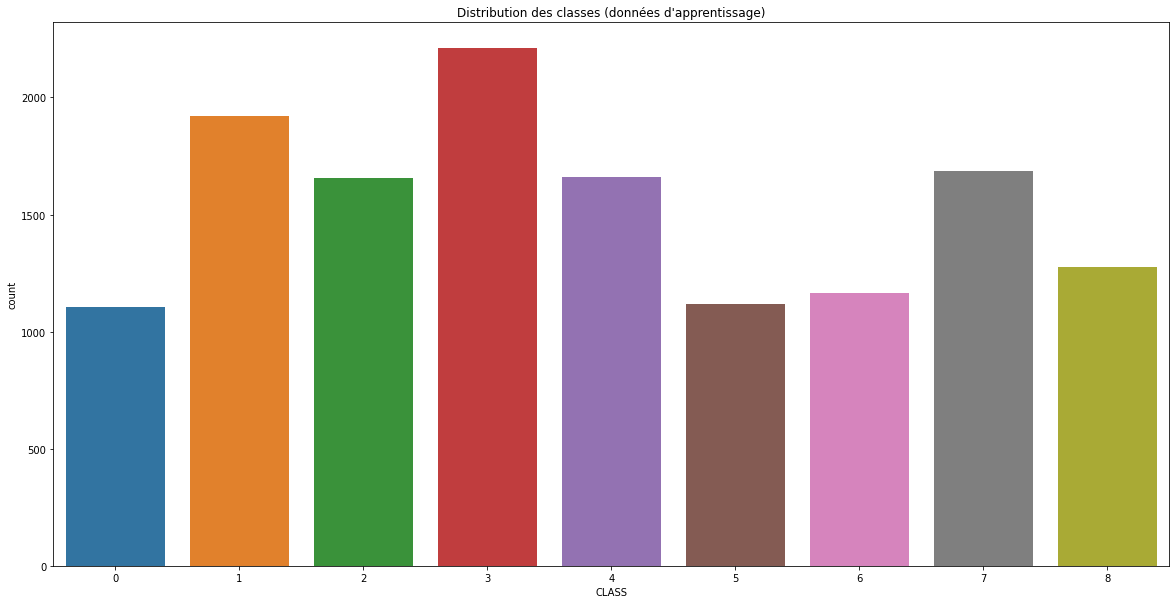

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(ax = ax, data= data_df, x= 'CLASS')
plt.title("Distribution des classes (données d'apprentissage)")
plt.show()

### Database image examples visualisation (training and test) | _Visualisation d'images de la base de données (apprentissage et test)_

We'll show a random image from each of the two datasets (training and test). We'll then determine their dimensions in order to know how to proceed.

_Commençons par visualiser une image quelconque parmi les images données pour chacun des deux datasets. Et déterminons ses dimensions afin de savoir comment procéder._

number of images: 13802
shape of each image: (256, 256, 3)
this is TRAIN image number 32
label: RIVER


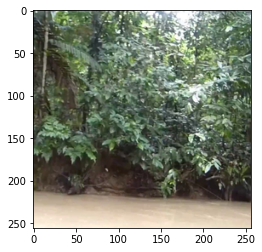

In [7]:
# visu image
idx = 32
class_list = ['FOREST', 'CITY', 'BEACH', 'CLASSROOM', 'RIVER', 'JUNGLE', 'RESTAURANT', 'GROCERY-STORE', 'FOOTBALL-MATCH']
img = Image.open(os.path.join(datadir, img_list.iloc[idx]))
plt.imshow(np.asarray(img))

print("number of images:",img_list.shape[0])
print("shape of each image:",np.asarray(img).shape)
print("this is TRAIN image number",idx)
print("label:",class_list[labels[idx]])

number of images: 3450
shape of each image: (256, 256, 3)
this is TEST image number 20


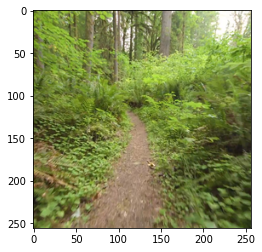

In [8]:
# visu test image
idx = 20
class_list = ['FOREST', 'CITY', 'BEACH', 'CLASSROOM', 'RIVER', 'JUNGLE', 'RESTAURANT', 'GROCERY-STORE', 'FOOTBALL-MATCH']
img = Image.open(os.path.join(datadir, test_img_list.iloc[idx]))
plt.imshow(np.asarray(img))
print("number of images:",test_img_list.shape[0])
print("shape of each image:",np.asarray(img).shape)
print("this is TEST image number",idx)

### 3. PyTorch: Configurations

The PyTorch library will be used to create our deep learning models.
If possible, we'll use the GPU to accelerate calculations.

_La bibliothèqe PyTorch sera utilisé pour faire nos modèles de deep learning.
On utilise la GPU au lieu de la CPU pour accélerer les calculs._

In [9]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
np.random.seed(0)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda



### 4. Dataset PyTorch

We then defined the Dataset class, to use with PyTorch

_Ensuite on définit la classe Dataset, nécessaire pour PyTorch_

In [10]:
class ImageAudioDataset(Dataset):
    def __init__(self, root_dir, files, audio, labels=None, img_transform=None, audio_transform=None):
        self.root_dir = root_dir
        self.files = files
        self.audio = audio
        self.labels = labels
        self.img_transform = img_transform
        self.audio_transform = audio_transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_dir, self.files.iloc[idx]))
        audio = self.audio[idx,:]
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.audio_transform is not None:
            audio = self.audio_transform(audio)
        if self.labels is not None:
            return img, audio, int(self.labels[idx])
        else:
            return img, audio

Then, we define the necessary transformations in order to input images to the network, and then we proceed to create the learning dataset.

_Puis, on définit les transformations nécessaires pour que les images puissent être entrées au réseau, et on fait l'instanciation du dataset d'apprentissage._

In [11]:
img_list_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

audio_transform = None

dataset = ImageAudioDataset(root_dir=datadir,
                                files=img_list,
                                audio=audio,
                                labels=labels,
                                img_transform=img_list_transform,
                                audio_transform=audio_transform)

### 5. Prediction Model | _Modèle de prediction_

#### 5.1 Only IMAGES | _Seulement IMAGES_

This was the first attempt of a network taking only images as input.
* We have used Transfer Learning, where we use a pre-trained network (in this case, ResNeXT, traned on the ImageNet database) to extract features from our specific image dataset.
* We then change the last layer of the network, in order to ouput 9 classes.
* This model obtaned a score of **94,811%** on Kaggle, so the next step was to include **audio** data to try and improve its performence.

----------

_Le premier réseau essayé admet seulement des images comme entrée._
* _C'est une démarche de Transfer Learning, où on part d'un réseau (ResNeXT) pré-appris (avec la base de données ImageNet)._
* _Après avoir téléchargé la réseau, on change sa dernière couche, pour avoir la classification en 9 classes à la fin du réseau._
* _Ce modèle a reussi une score de **94,811%** sur Kaggle, mais il nous faudrait inclure les données **audio**._

In [15]:
# On charge une réseau pré-appris, sans changer les poids et biais
resnext = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
for p in resnext.parameters():
    p.requires_grad = False # on va pas descendre le gradient

# Changer la derniere couche - par standard, elle va descendre le gradient
num_ftrs = resnext.fc.in_features
resnext.fc = nn.Linear(num_ftrs, 9) # La sortie de la réseau va etre les 9 classes

# Pour utiliser la GPU
if device.type == 'cuda':
    resnext = resnext.cuda()
    
model = resnext

#### **5.2 IMAGES + AUDIO**

As a first "multimodal" model, we propose `MyModel1`, a neural network with the following architecture:
- The images go through a pre-trained network, so the output is `x1` vector of size=32
- The audio data (vector of size 104) goes through a MLP layer which has as output an `x2` vector of size=32
- These two outputs are concatenated into one vector `x`, creating a vector of size=64
- We apply a Relu activation function to this last layer
- Finally, the output goes through an MLP layer, which outputs a vector of size=9 (9 possible classes)

----------

_Comme premier modèle "multimodal", on a proposé `MyModel1`, qui est un réseau de neurone ayant l'architecture suivante:_
- _Les images passent par un réseau pré-entrainé, dont la sortie est un vecteur `x1` de taille 32_
- _Les audios passent par une couche MLP dont l'entrée est un vecteur de taille 104 et la sortie est un vecteur `x2` de taille 32_
- _Ces deux sorties seront concaténées en un seul vecteur `x` dont la sortie est de taille 64
- _On applique une activation Relu à cette dernière_
- _Enfin, la sortie passe par une couche MLP ayant en entrée un vecteur de taille 64 et en sortie un vecteur de taille 9 ( 9 classes à prédire)_


In [12]:
class MyModel1(nn.Module):
    def __init__(self):
        super(MyModel1, self).__init__()
        
        self.resnext = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
        
        num_ftrs = self.resnext.fc.in_features
        self.resnext.fc = nn.Linear(num_ftrs,32)
        
        self.fc1 = nn.Linear(104,32)
        self.ac = nn.ReLU()  
        self.fc2 = nn.Linear(64,9)
        
    def forward(self, img,audio):
        x1 = self.resnext(img)      
        x2 = self.fc1(audio)

        x = torch.cat((x1,x2),1)
        x= self.ac(x)
        x = self.fc2(x)

        return x

However, this first model did not result in a very good score, and then we have created a second model with the same general architecture, but with some parameters changed.

_Néanmoins, ce premier modèle n'a pas aboutit à un résultat de grande performance.
D'où le recours à un deuxième modèle ayant la même architecture, mais avec changement de quelques paramètres._

The second model proposition is `MyModel2`, where the image input generates a vector `x1` of size=20, the audio input generates a vector `x2` of size=10, and the result of their concatenation, `x`, of size=30, hoes through a ReLU before being used as input to a MLP layer which outputs the 9 classification neurons.
In this network, we're using a pre-trained ResNeXT with less layers than the version used on the last model.

This second model resulted on a score of **99,65%** on the hidden data on Kaggle, which are very good results.

---------

_Le deuxième modèle proposé est `MyModel2`, où la partie image résulte en un vecteur `x1` de taille 20, la partie audio résulte en un vecteur `x2` de taille 10, et la concaténation `x` de taille 30 passe par un ReLU avant d'être utilisée comme entrée d'une couche MLP qui a comme sortie les 9 neurones de classification.
De surcroit, on part d'un réseau (ResNeXT) pré-appris qui a moins de couches que le précédent._

_Ce modèle nous a donné de très bons résultats, notamment le score **99,65%** sur Kaggle._

In [13]:
class MyModel2(nn.Module):
    def __init__(self):
        super(MyModel2, self).__init__()
        
        
        self.resnext = torchvision.models.resnet18(pretrained=True)
        
        num_ftrs = self.resnext.fc.in_features
        self.resnext.fc = nn.Linear(num_ftrs,20)

        self.fc1 = nn.Linear(104,10)
        self.ac1 = nn.ReLU()
        
        self.fc2 = nn.Linear(30,9)


    def forward(self, img,audio):
        x1 = self.resnext(img)
        x2 = self.fc1(audio)
        
        x = torch.cat((x1,x2),dim=1)
        x = self.ac1(x)
        x = self.fc2(x)

        return x

In [14]:
# model = MyModel1()
model = MyModel2()
model = model.to(device)

### 6. Learning configurations | _Configurations d'apprentissage_

Here, we're configuring the learning parameters of the model.
Since we are using Transfer Learning, the Learning Rate used is rather small. This need was observed after some tests, looking at the evolution of the **loss** parameter during the learning process.

_Ici, on configure les paramétres d'apprentissage du modèle._
_Comme on fait une démarche de Transfer Learning, on choisit la Learning Rate assez petite. Cela a été conclut aprés quelques essaies, en regardant l'évolution de la **loss** lors de l'apprentissage._

In [16]:
# Configurations de l'apprentissage
softmax = torch.nn.Softmax(dim=1)
learning_rate=0.001
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion=nn.CrossEntropyLoss()
epochs = 10

### 7. Validation

#### 7.1. Validating the model using the *K-Fold* method | _Validation en utilisant la méthode *K-Fold*_

To have insight on our model's capacity of classifying new data, we have tested two validation methods.
The first was the K-Fold method.

_Pour avoir une idéee sur la capacité de notre modèle d'évaluer de nouvelles données, on a utilisé deux démarches de validation._
_La première était la méthode K-Fold._

> Obs: The main goal of the K-Fold method on this case is to compare the two proposed models.

> _Remarque: Le but principal de cette méthode KFold  était de comparer les deux modéles qu'on a proposé._

In [17]:
kf = KFold(n_splits=5,shuffle=True)
## Taille du batch
nsample = 64
epochs = 10

for fold,(train_index, test_index) in enumerate(kf.split(dataset)):
    
    print("fold n",fold)

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_index)

    print("total: ",len(dataset),"train: ",len(train_index),"test: ",len(test_index))
    #echantillonner les données
    datatrain_loader = DataLoader(dataset, batch_size=nsample,sampler=train_subsampler)
    datatest_loader = DataLoader(dataset, batch_size=nsample,sampler=test_subsampler)
    
    ###########################################################

    for epoch in range(epochs):
        print("epoch:",epoch)
        acc = []
        for i,data in enumerate(tqdm(datatrain_loader)):
            img, audio, label = data
            img,audio,label = img.to(device), audio.to(device), label.to(device) 
            
            output = model(img,audio)
            loss=criterion(output,label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y_pred = softmax(output)
            label_pred = torch.argmax(y_pred,dim=1)
            acc.append(float(torch.sum(label_pred==label)/len(label_pred)))
        print(np.sum(acc)/len(acc))


    with torch.no_grad():
        acc = []
        for i,data in enumerate(tqdm(datatest_loader)):
            img, audio, label = data
            img,audio,label = img.to(device), audio.to(device), label.to(device) 
            output = model(img,audio)
            loss=criterion(output,label)
            y_pred = softmax(output)
            label_pred = torch.argmax(y_pred,dim=1)
            acc.append(float(torch.sum(label_pred==label)/len(label_pred)))
    print("test :",np.sum(acc)/len(acc))

  0%|          | 0/70 [00:00<?, ?it/s]

fold n 0
total:  13802 train:  6901 test:  6901
epoch: 0


  0%|          | 0/70 [00:00<?, ?it/s]

0.18914285286196642
epoch: 1


  0%|          | 0/70 [00:00<?, ?it/s]

0.36185713240078515
epoch: 2


  0%|          | 0/70 [00:00<?, ?it/s]

0.4954285583325795
epoch: 3


  0%|          | 0/70 [00:00<?, ?it/s]

0.5642857002360481


  0%|          | 0/70 [00:00<?, ?it/s]

test : 0.5165714140449251
fold n 1
total:  13802 train:  6901 test:  6901
epoch: 0


  0%|          | 0/70 [00:00<?, ?it/s]

0.6164285587412971
epoch: 1


  0%|          | 0/70 [00:00<?, ?it/s]

0.6875714080674308
epoch: 2


  0%|          | 0/70 [00:00<?, ?it/s]

0.748999982220786
epoch: 3


  0%|          | 0/70 [00:00<?, ?it/s]

0.7931428338800158


100%|██████████| 70/70 [01:00<00:00,  1.15it/s]

test : 0.7687142644609724


#### 7.2. Model validation using the *train/validation* method | _Validation en utilisant la méthode *train/validation*_

We have used a split of 80% for learning and 20% for validation.

_On a utilisé un split de 80% pour l'apprentissage et 20% pour validation._

In [ ]:
df_train, df_test= train_test_split(dataset, test_size=0.20,shuffle=True)

In [ ]:
print("total",len(dataset))
print("train",len(df_train))
print("test",len(df_test))

In [ ]:
## Taille du batch
nsample = 64
# Shuffle = false pour echantillonner les données dans l'ordre
datatrain_loader = DataLoader(df_train, batch_size=nsample, shuffle=True)
dataval_loader = DataLoader(df_test, batch_size=nsample, shuffle=True)


Learning with 80% of the data.

_Apprentissage du modèle avec 80% des données._

In [ ]:
for epoch in range(epochs):
    model.train()
    print("epoch", epoch)
    for data in datatrain_loader:
        img, audio, label = data
        img,audio,label = img.to(device), audio.to(device), label.to(device) 
        img, label = img.to(device), label.to(device) 
                
        output = model(img,audio) # if using a model that has audio and image as inputs
#         output = model(img) # if using a model that has only image as input
    
        loss=criterion(output,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if random.randint(0,20)==0:
            print("\tloss=",loss) ## on affiche pour valider que ça diverge pas

Validating the model with the remaining 20% of the data.

_Validation du modèle appris avec les 20% des données restantes._

In [ ]:
with torch.no_grad():
    acc = []
    model.eval()
    for data in dataval_loader:
        img, audio, label = data
        img = img.to(device)
        label = label.to(device)
        output = model(img,audio) # if using a model that has audio and image as inputs
#         output = model(img)  # if using a model that has only image as input
        loss=criterion(output,label)
        y_pred = softmax(output)
        label_pred = torch.argmax(y_pred,dim=1)
        acc.append(float(torch.sum(label_pred==label)/len(label_pred)))
print(np.sum(acc)/len(acc))
# print(y_pred[1])
# print(label_pred[1])

The validation results were:
* **98,75%** of *accuracy* with the **Train/Validation split**
* **99,00%** of *accuracy* with the **K-Fold**

After obtaining these good results, we'll pass to the final learning phase, using all of the available data:

------

_Les résultats de validation étaient:_
* **98,75%** d'*accuracy* avec le **Train/Validation split**
* **99,00%** d'*accuracy* avec le **K-Fold**

_Aprés avoir obtenu de très bons résultats, on va maintenant faire l'apprentissage avec tous les données:_

### 8. Final learning with all of the data | _Apprentissage finale avec tous les données_

For the final learning phase, we'll create the DataLoader with all of the data and run the learning once more.

_Pour l'apprentissage finale, il nous reste que créer le DataLoader avec toutes les données et faire l'apprentissage._

In [ ]:
model = MyModel2()
model = model.to(device)

In [ ]:
nsample = 64
datafull_loader = DataLoader(dataset, batch_size=nsample, shuffle=True)

In [ ]:
for epoch in range(epochs):
    model.train()
    print("epoch", epoch)
    for data in datafull_loader:
        img, audio, label = data
        
        # if using a model that has audio and image as inputs
        img,audio,label = img.to(device), audio.to(device), label.to(device) 
        output = model(img,audio)
        
        # if using a model that has only image as input
#         img, label = img.to(device), label.to(device)                 
#         output = model(img)
    
        loss=criterion(output,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if random.randint(0,20)==0:
            print("\tloss=",loss) ## on affiche pour valider que ça diverge pas
            

### 9. Class inference for unlabeled data | Prédiction des données sans label

Finally, we will predict the final labels, used in the Kaggle submission.

_Enfin, on réalise la prédiction finale qui va générer les labels de la submission._

In [ ]:
from tqdm import tqdm 

## Taille du batch
nsample = 64

test_dataset = ImageAudioDataset(root_dir=datadir,
                                files=test_img_list,
                                audio=test_audio,
                                labels=None,
                                img_transform=img_list_transform,
                                audio_transform=None)

datatest_loader = DataLoader(test_dataset, batch_size=nsample,shuffle=False)

pred_labels = []

with torch.no_grad():
    model.eval()
    for i,data in enumerate(tqdm(datatest_loader)):
        img,audio = data
        img,audio = img.to(device), audio.to(device)
#         output = model(img)
        output = model(img, audio)
        y_pred = softmax(output)
        label_pred = torch.argmax(y_pred,dim=1)
        for label in label_pred:
            pred_labels.append(int(label))




Verifying the format of the output.

_On vérifie le format des labels qu'a donné le modèle comme sortie._

In [ ]:
print(pred_labels)

We can visualize images of the test database, printing along them the predicted label, which allows for visual debugging/verification if needed.

_On peut visualizer des images de la base de données du test, en affichant le label prévu par le modèle, ce qui nous permet de faire une vérification visuelle, si besoin._

In [ ]:
# visu image
idx = 56
class_list = ['FOREST', 'CITY', 'BEACH', 'CLASSROOM', 'RIVER', 'JUNGLE', 'RESTAURANT', 'GROCERY-STORE', 'FOOTBALL-MATCH']
img = Image.open(os.path.join(datadir, test_img_list.iloc[idx]))
plt.imshow(np.asarray(img))

print("number of images:",test_img_list.shape[0])
print("shape of each image:",np.asarray(img).shape)
print("this is TEST image number",idx)
print("predicted class:",class_list[pred_labels[idx]])

### 10. Generating and saving the submission file | _Géneration et sauvegarde du fichier de submission_

In [ ]:
submission = pd.DataFrame({'CLASS':pred_labels})
submission=submission.reset_index()
submission = submission.rename(columns={'index': 'Id'})

print("number of images:",len(submission))
submission.to_csv('submissionAmaniCaioTest.csv',index=False)

### Conclusion

We were able to conclude that the proposed model is adequate to the solving of this problem, and the use of multimodal data allowed the improvement of the model's accuracy.
Even though the accuracy for this dataset is very high, the model could be improved further by using tools such as Grid Search.

_En guise de conclusion, on pourra déduire que l'architecture du modéle proposée est adéquate à la résolution de ce problème._
_Mais bien evidemment, malgré que la précision est d'environ 99,65%, le modéle peut être amélioré en modifiant quelques paramétres: qui eux même peuvent être déterminés à partir de Grid Search._